# Stage1

This notebook describes the inital setup of the stereoseq annData object in midbrain sections

# SETUP

### Load packages and set variables

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import glob
import re
from joblib import Parallel, delayed
from functools import partial
import scipy.sparse
import seaborn as sns
# import scanpy_gpu_funcs as rsf
# import cudf
# import cupy as cp
# from cuml.decomposition import PCA
from scipy.sparse import issparse
from SCTransform import SCTransform
from tqdm import tqdm
import pickle
# import bbknn
from tqdm import tqdm

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
from matplotlib import rcParams
sc.set_figure_params(dpi= 100, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

# import rmm
# rmm.reinitialize(
#     managed_memory=True, # Allows oversubscription
#     pool_allocator=False, # default is False
#     devices=0, # GPU device IDs to register. By default registers only GPU 0.
# )
# cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

os.chdir('/active/paper/')


## Load metadata (removing 454TL_E2)

In [2]:
sample_metadata = pd.read_csv('input/metadata/sample_metadata_midbrain.txt', sep='\t', index_col=['sample'])
# set names
names = list(sample_metadata.index)
names.remove('FP200000454TL_E2')

## Midbrain XY orientation adjustment

In [3]:
def fix_midbrain_orientation(adata):
    
    adata.obs['x_orig'] = adata.obs['x']
    adata.obs['y_orig'] = adata.obs['y']

    adata.obs['x'] = adata.obs['x_orig']
    adata.obs['y'] = adata.obs['y_orig']

    # FP200000542BR_A5
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A5', 'y'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A5', 'y'] * -1
    # FP200000542BR_F3
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_F3', 'y'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_F3', 'y'] * -1
    # FP200000578TR_C3
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C3', 'x'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C3', 'y_orig']
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C3', 'y'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C3', 'x_orig']
    # FP200000578TR_C5
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C5', 'x'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C5', 'y_orig']
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C5', 'y'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000578TR_C5', 'x_orig']
    # FP200000542BR_A1
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A1', 'x'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A1', 'y_orig']
    adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A1', 'y'] = adata.obs.loc[adata.obs['sample_id'] == 'FP200000542BR_A1', 'x_orig']

    # update spatial obsm
    adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()

## Load sparse matrices

In [4]:
# load sparses, gene IDs, xys
def load_sparses_geneIDs_xys(name):
    sparse = scipy.sparse.load_npz('input/sparses/'+name+'.npz')
    gene_IDs = pd.read_csv('input/gene_ids/'+name+'.csv.gz', 
                usecols=['geneID_int', 'geneID'], 
                index_col=['geneID_int']).sort_index().drop_duplicates()
    xy = pd.read_csv('input/xy/'+name+'.csv.gz', index_col=['cell_ID'])
    return(sparse, gene_IDs, xy)

# data = Parallel(n_jobs=-2)(delayed(load_sparses_geneIDs_xys)(name) for name in names)
# data = dict(zip(names, data))

data = {}
for name in tqdm(names):
    data[name] = dict(zip(['sparse', 'gene_IDs', 'xy'], load_sparses_geneIDs_xys(name)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.05it/s]


## Create adata objects

In [5]:
# create anndata objects
adatas = {}

def create_adata(name):
    print(name)
    adata = sc.AnnData(X=data[name]['sparse'], var=data[name]['gene_IDs'], obs=data[name]['xy'])
    # adata.X = adata.X.astype('int')
    adata.var_names = adata.var['geneID']
    adata.obs['sample_id'] = sample_metadata.loc[name].name
    adata.obs['mouse_id'] = sample_metadata.loc[name]['sample_name']
    # adatas[name].obs['region'] = sample_metadata.loc[name]['region']
    adata.obs['age'] = sample_metadata.loc[name]['age']
    adata.obs['genotype'] = sample_metadata.loc[name]['genotype']
    adata.obs_names = adata.obs['sample_id'] + '_' + adata.obs_names.astype('str')
    adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
        
    # QC
    adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.str.startswith('Rp')  # annotate the group of ribosomal genes as 'ribo'
    adata.var['hb'] = adata.var_names.str.startswith('Hb')  # annotate the group of haemoglobin genes as 'hb'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], log1p=True, inplace=True)

    # store unnormalised counts
    adata.layers["counts"] = adata.X.copy()
    
    # process for integration with scanorama
    # SCTransform(adata, min_cells=25, gmean_eps=1, n_genes=5000, n_cells=None, # use all cells
    #             bin_size=5000, bw_adjust=3, inplace=True)
    # adata.var['highly_variable'] = ~pd.isna(adata.var['Intercept_step1_sct'])
    # sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed = True, max_fraction=0.01)
    # sc.pp.log1p(adata)
        
    return(adata)

# parallel preparation
names = names
adatas = Parallel(n_jobs=len(names))(delayed(create_adata)(name) for name in tqdm(names))

# zip the dict
adatas = dict(zip(names, adatas))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 62.92it/s]
/tmp/ipykernel_3754167/1604090096.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_3754167/1604090096.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this

## Plot QC

In [9]:
adata_spatial

AnnData object with n_obs × n_vars = 374841 × 23642
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes'
    var: 'geneID', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0-0-0-0-0-0', 'mean_counts-0-0-0-0-0-0', 'log1p_mean_counts-0-0-0-0-0-0', 'pct_dropout_by_counts-0-0-0-0-0-0', 'total_counts-0-0-0-0-0-0', 'log1p_total_counts-0-0-0-0-0-0', 'n_cells_by_counts-1-0-0-0-0-0', 'mean_counts-1-0-0-0-0-0', 'log1p_mean_counts-1-0-0-0-0-0', 'pct_dropout_by_counts-1-0-0-0-0-0', 'total_counts-1-0-0-0-0-0', 'log1p_total_counts-1-0-0-0-0-0', 'n_cells_by_counts-1-0-0-0-0', 'mean_counts-1

/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


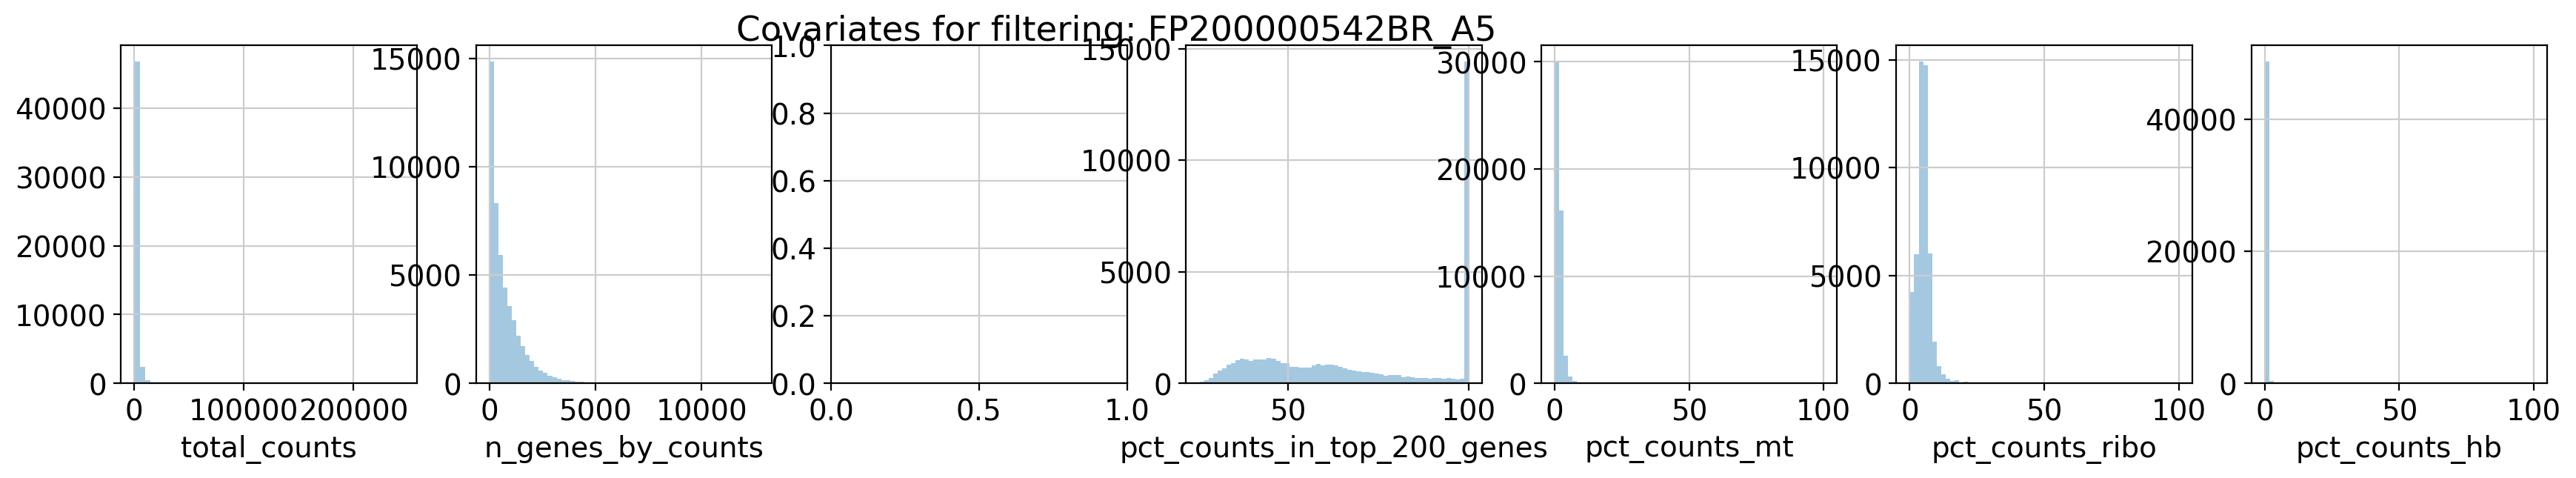

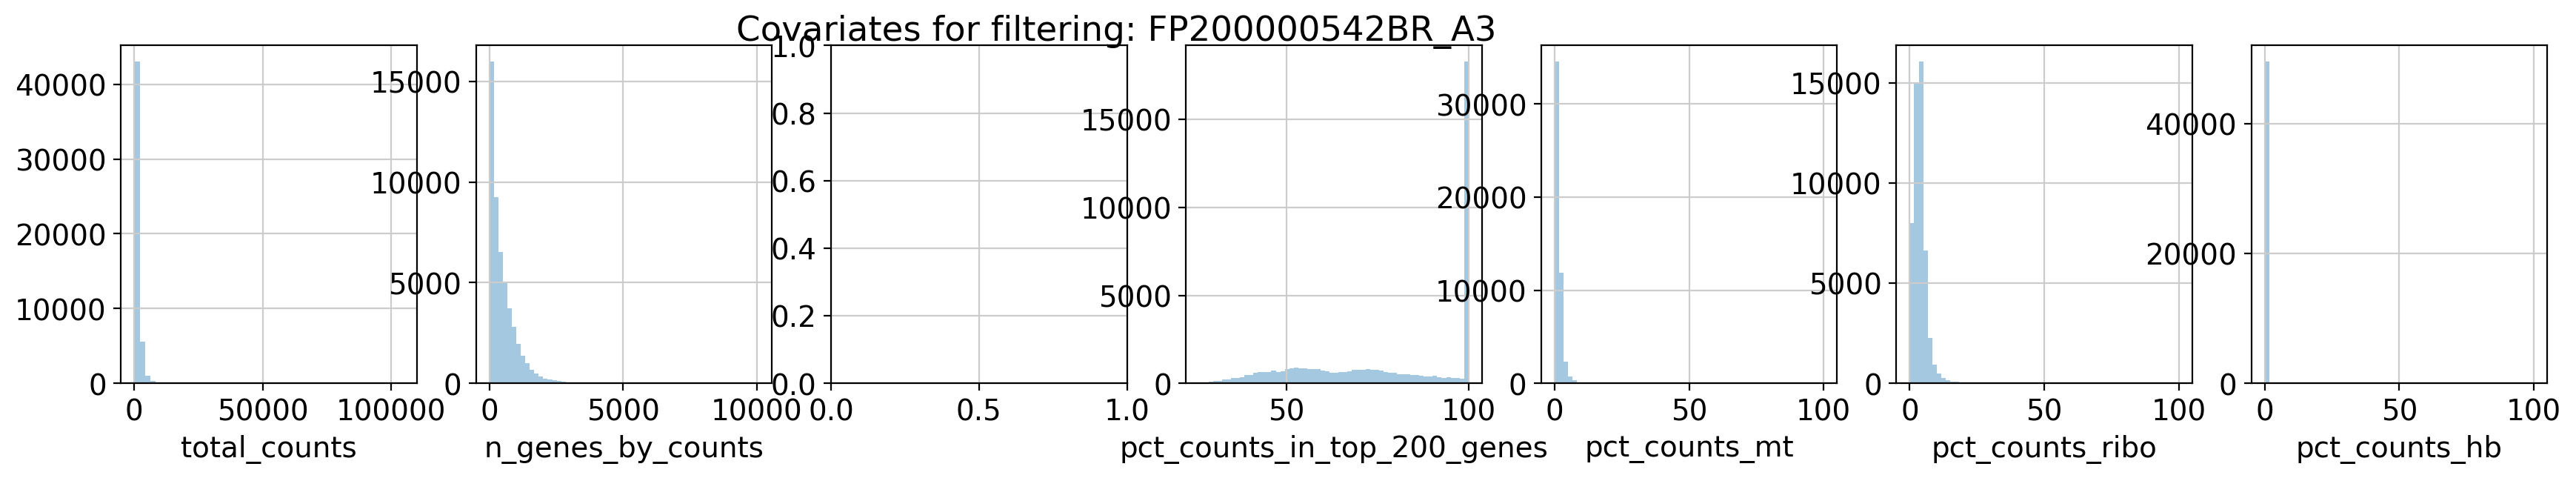

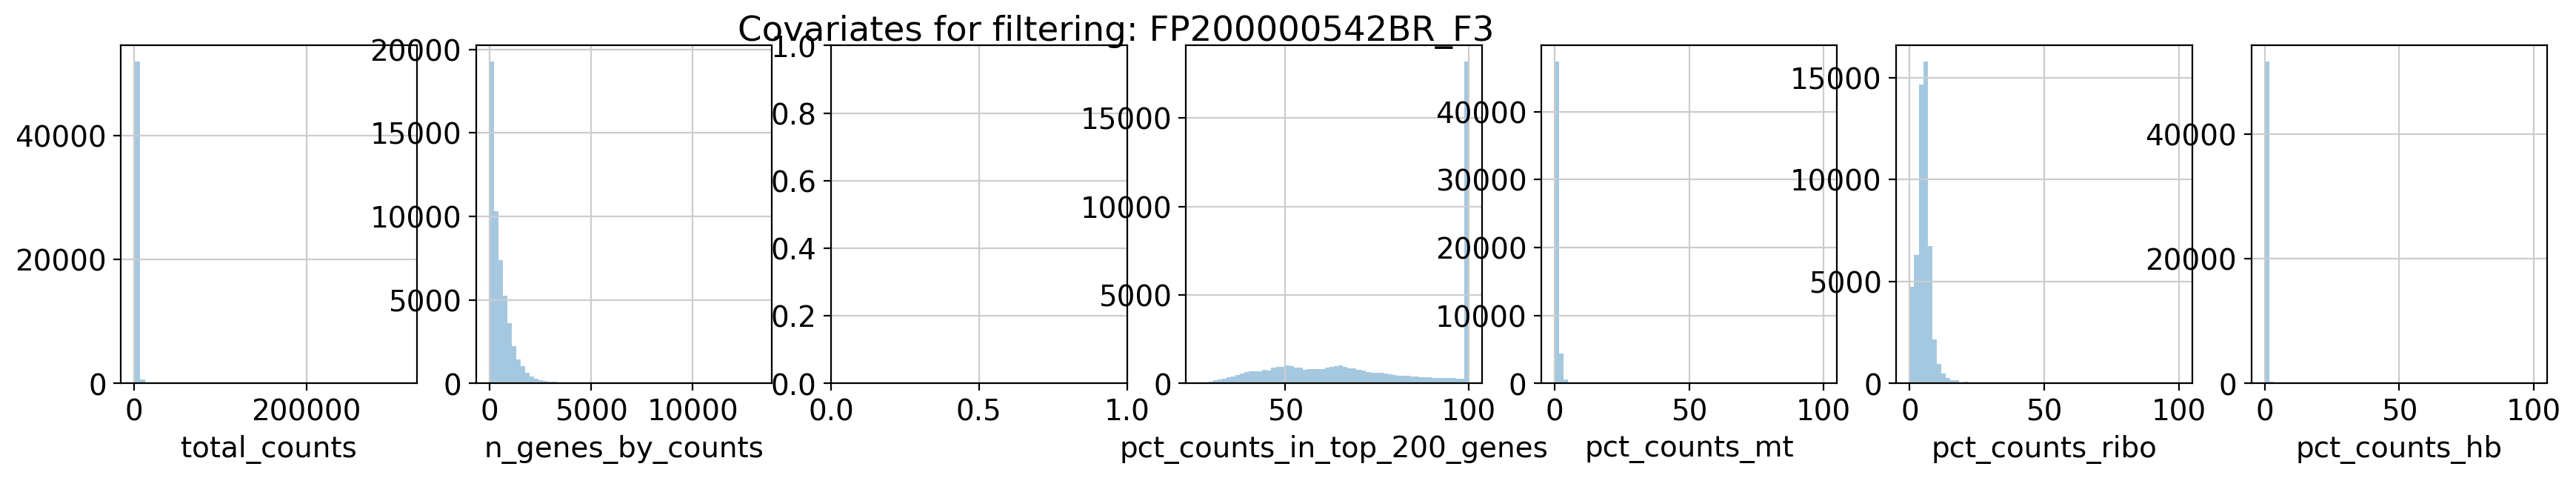

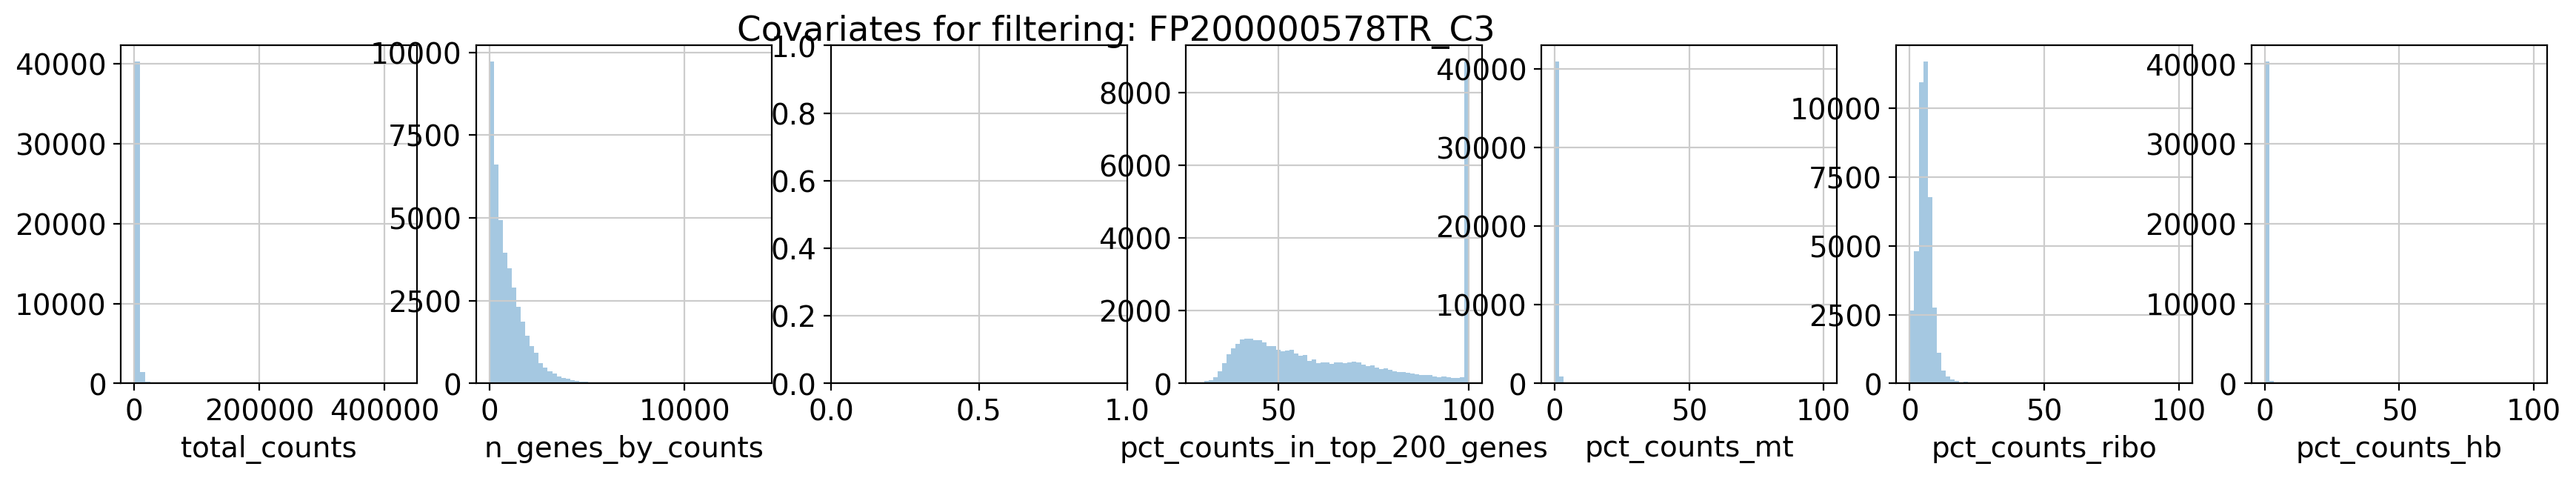

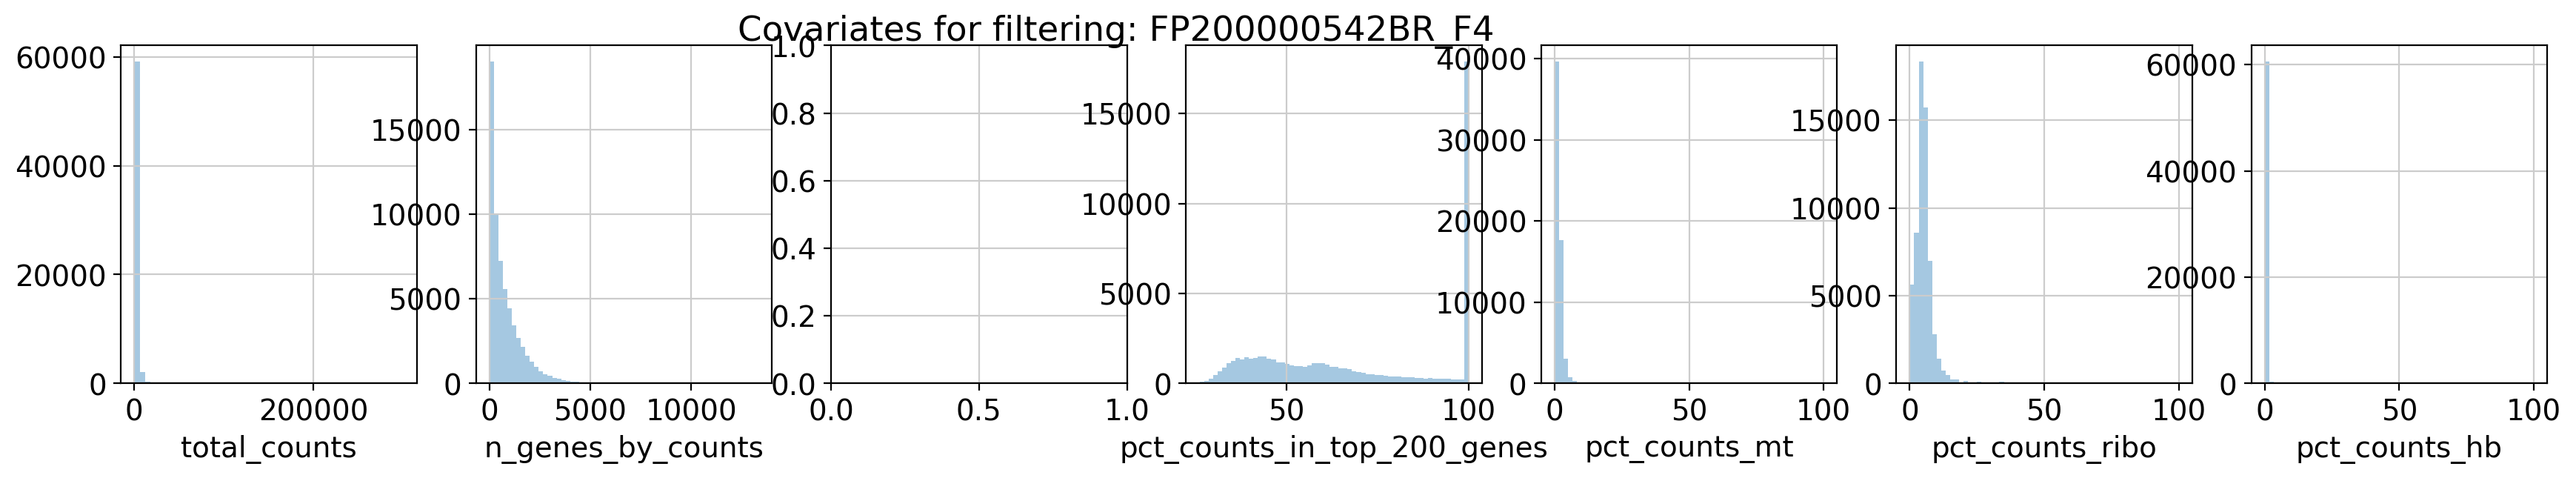

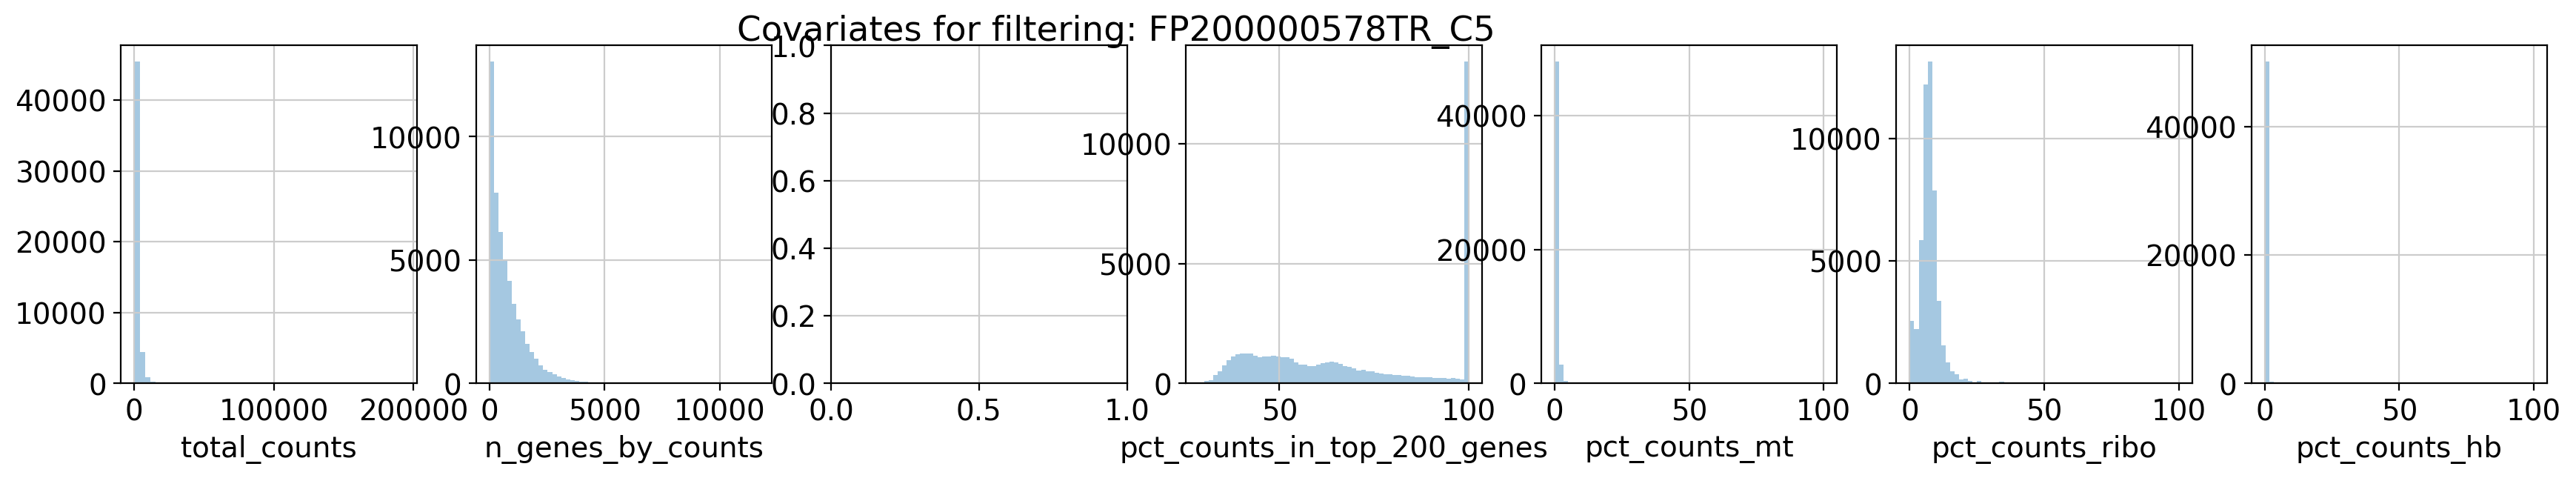

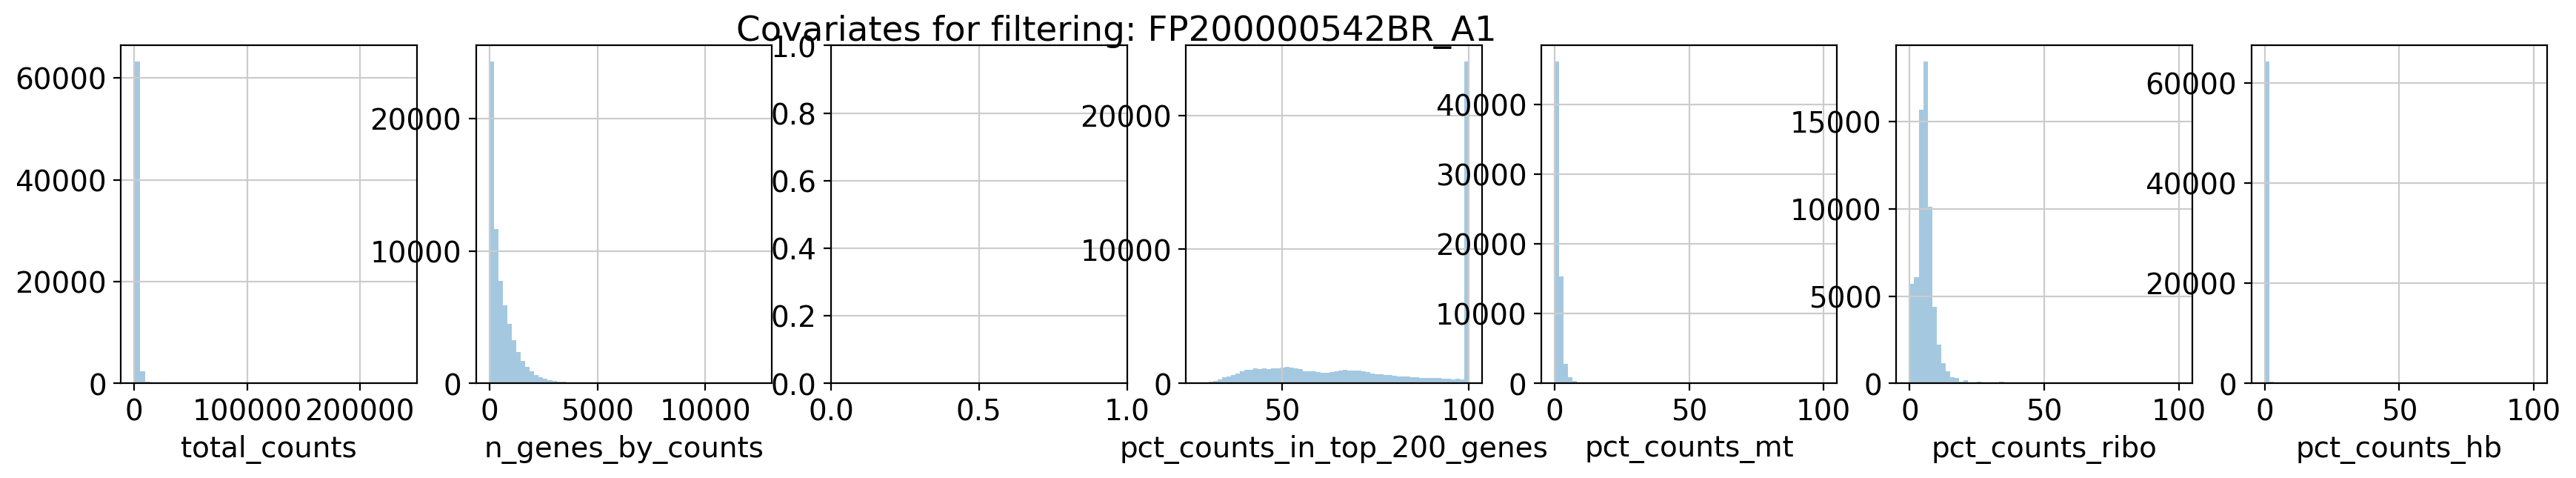

In [6]:
for name, adata in adatas.items():
    fig, axs = plt.subplots(1, 7, figsize=(21, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
    # sns.distplot(adata.obs["n_genes"], kde=False, bins=60, ax=axs[2])
    sns.distplot(adata.obs['pct_counts_in_top_200_genes'], kde=False, bins=60, ax=axs[3])
    sns.distplot(adata.obs['pct_counts_mt'], kde=False, bins=60, ax=axs[4])
    sns.distplot(adata.obs['pct_counts_ribo'], kde=False, bins=60, ax=axs[5])
    sns.distplot(adata.obs['pct_counts_hb'], kde=False, bins=60, ax=axs[6])

## Concatenate adatas

In [7]:
# # concatenate and QC
# adata_spatial = adatas[names[0]]

# for name in names[1:]:
#     adata_spatial.obs_names = [c.split("-")[0] for c in adata_spatial.obs_names]
#     adata_spatial.obs_names_make_unique(join='_')
#     adata_spatial = adata_spatial.concatenate(adatas[name])
    
# adata_spatial.obs_names = [c.split("-")[0] for c in adata_spatial.obs_names]
# adata_spatial.var['mt'] = adata_spatial.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
# adata_spatial.var['ribo'] = adata_spatial.var_names.str.startswith('Rp')  # annotate the group of ribosomal genes as 'ribo'
# adata_spatial.var['hb'] = adata_spatial.var_names.str.startswith('Hb')  # annotate the group of haemoglobin genes as 'hb'
# adata_spatial.var['Malat1'] = adata_spatial.var_names.str.startswith('Malat1')

# adata_spatial.obs['n_genes'] = np.sum(adata_spatial.X, axis=1)

/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from 

In [8]:
# adata_spatial.obs.to_csv('output/figures/supplementary/spatial_qc.csv', index_label='cell_id')

FP200000542BR_A3
FP200000578TR_C5
FP200000542BR_F3
FP200000542BR_F4
FP200000542BR_A5
FP200000578TR_C3
FP200000542BR_A1


In [13]:
# adata_spatial.var.to_csv('output/figures/supplementary/spatial_qc_var.csv', index_label='cell_id')

FP200000542BR_F3
FP200000542BR_A5
FP200000542BR_A3
FP200000542BR_A1
FP200000542BR_F4
FP200000578TR_C3
FP200000578TR_C5


In [10]:
# concatenate and QC
adata_spatial = adatas[names[0]]

for name in names[1:]:
    adata_spatial.obs_names = [c.split("-")[0] for c in adata_spatial.obs_names]
    adata_spatial.obs_names_make_unique(join='_')
    adata_spatial = adata_spatial.concatenate(adatas[name])
    
# basic filtering
sc.pp.filter_cells(adata_spatial, min_genes=200)
sc.pp.filter_cells(adata_spatial, max_genes=3000)
sc.pp.filter_genes(adata_spatial, min_cells=100)
    
adata_spatial.obs_names = [c.split("-")[0] for c in adata_spatial.obs_names]
adata_spatial.var['mt'] = adata_spatial.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
adata_spatial.var['ribo'] = adata_spatial.var_names.str.startswith('Rp')  # annotate the group of ribosomal genes as 'ribo'
adata_spatial.var['hb'] = adata_spatial.var_names.str.startswith('Hb')  # annotate the group of haemoglobin genes as 'hb'
adata_spatial.var['Malat1'] = adata_spatial.var_names.str.startswith('Malat1')

# backup counts
adata_spatial.layers['counts'] = adata_spatial.X.copy()
# adata_spatial.raw = adata_spatial

/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/peter/miniconda3/envs/paper_stage1/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from 

In [11]:
adata_spatial

AnnData object with n_obs × n_vars = 253270 × 19241
    obs: 'x', 'y', 'sample_id', 'mouse_id', 'age', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'n_genes'
    var: 'geneID', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0-0-0-0-0-0', 'mean_counts-0-0-0-0-0-0', 'log1p_mean_counts-0-0-0-0-0-0', 'pct_dropout_by_counts-0-0-0-0-0-0', 'total_counts-0-0-0-0-0-0', 'log1p_total_counts-0-0-0-0-0-0', 'n_cells_by_counts-1-0-0-0-0-0', 'mean_counts-1-0-0-0-0-0', 'log1p_mean_counts-1-0-0-0-0-0', 'pct_dropout_by_counts-1-0-0-0-0-0', 'total_counts-1-0-0-0-0-0', 'log1p_total_counts-1-0-0-0-0-0', 'n_cells_by_counts-1-0-0-0-0', 'mean_counts-1

## Recalculate QC

In [17]:
# new QC
sc.pp.calculate_qc_metrics(adata_spatial, 
                           use_raw=False, 
                           qc_vars=['mt', 'ribo', 'hb', 'Malat1'], 
                           log1p=True, 
                           inplace=True)

adata_spatial.var = sc.pp.calculate_qc_metrics(adata_spatial, 
                           use_raw=False, 
                           qc_vars=['mt', 'ribo', 'hb', 'Malat1'], 
                           log1p=True, 
                           inplace=False)[1]

## Plot the highest expressed genes

<AxesSubplot:xlabel='% of total counts', ylabel='geneID'>

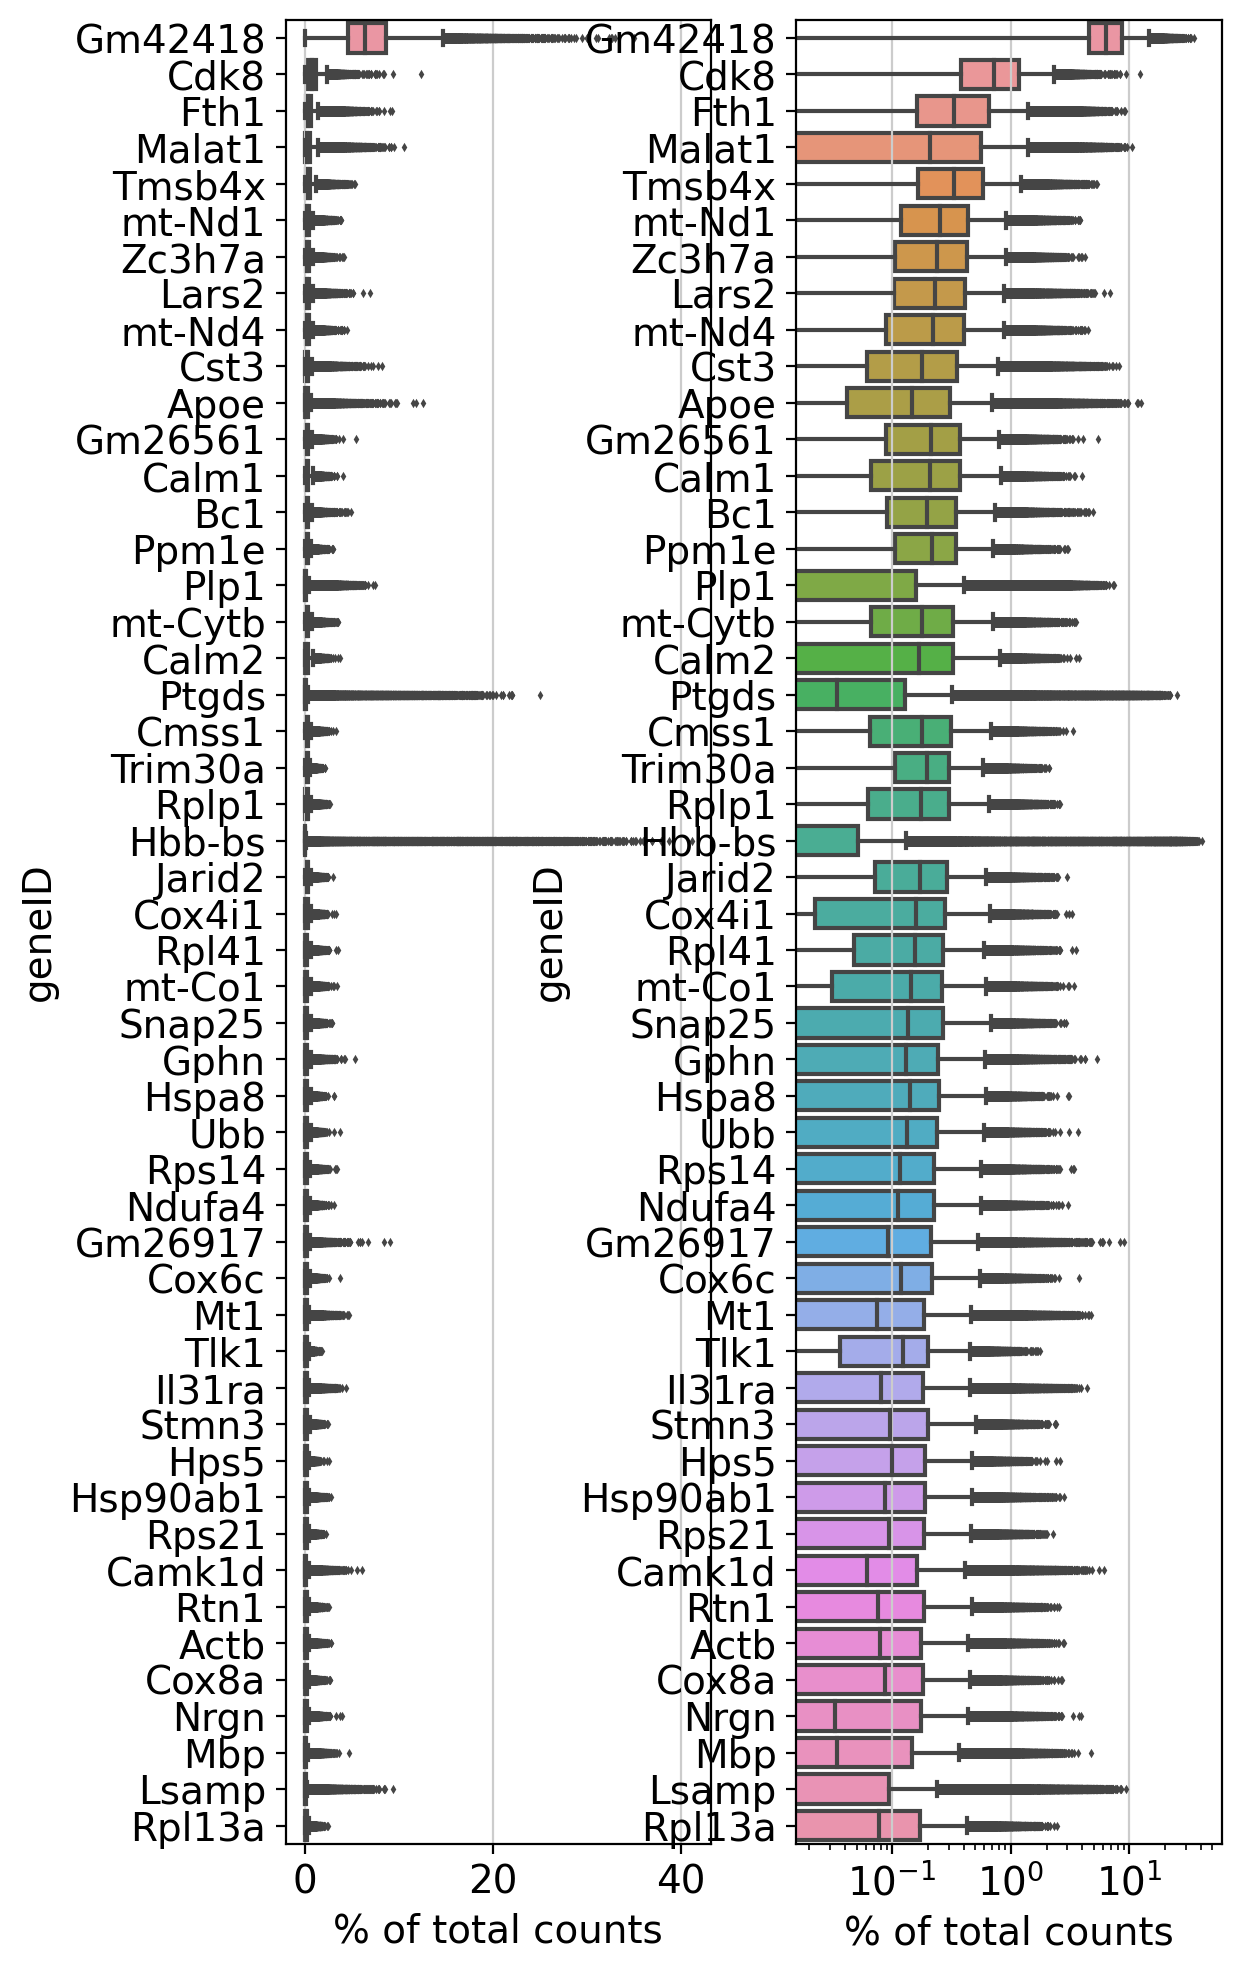

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 12))
axs = axs.ravel()

sc.pl.highest_expr_genes(adata_spatial, n_top=50, ax=axs[0], show=False)
sc.pl.highest_expr_genes(adata_spatial, n_top=50, log=True, ax=axs[1], show=False)

## Remove Gm42418

In [19]:
adata_spatial = adata_spatial[:,adata_spatial.var.index != 'Gm42418'].copy()

## Clean up

In [20]:
del adata
del adatas

## Adjust XY orientation

In [21]:
fix_midbrain_orientation(adata_spatial)

## Create full backup

In [22]:
with open('input/adata/midbrain/adata_spatial.pickle', 'wb') as f:
    pickle.dump(adata_spatial, f)

FP200000542BR_A3


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000542BR_A5


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000578TR_C3


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000542BR_A1


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000578TR_C5


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000542BR_F4


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


FP200000542BR_F3


/tmp/ipykernel_620014/3838390574.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/peter/miniconda3/envs/paper-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
